## O método Holt-Winters 

Na aula 07 nós utiizamos Suavização Exponencial Simples usando apenAs o favor de suavização $\alpha$ (alpha). Isto não levou em conta outros fatores importantes, como tendência e sazonalidade.

Nesta aula estudaremos Suavização Exponencial Dupla e Tripla utilizando o método de <a href='https://otexts.com/fpp2/holt-winters.html'>Holt-Winters</a>.

Na Suavização Exponencial Dupla (método de Holt), um novo fator de suavização $\beta$ (beta) é introduzido. Sua função é tratar a tendência:

\begin{split}l_t &= (1 - \alpha) l_{t-1} + \alpha x_t, \\
b_t &= (1-\beta)b_{t-1} + \beta(l_t-l_{t-1}) \\
y_t &= l_t + b_t \\
\hat y_{t+h} &= l_t + hb_t \end{split}

Tendo em vista que ainda não consideramos as flutuações sasonais, o modelo de previsão é simplesmente uma linha reta inclinada que se estende desde o ponto de dados mais recente.

Com a Suavização Exponencial Tripla (método Holt-Winters), o fator de suavização $\gamma$ (gamma) é introduzido para tratar a sasonaliade:

\begin{split}l_t &= (1 - \alpha) l_{t-1} + \alpha x_t, \\
b_t &= (1-\beta)b_{t-1} + \beta(l_t-l_{t-1}) \\
c_t &= (1-\gamma)c_{t-L} + \gamma(x_t-l_{t-1}-b_{t-1}) \\
y_t &= (l_t + b_t) c_t \\
\hat y_{t+m} &= (l_t + mb_t)c_{t-L+1+(m-1)modL} \end{split}

Aqui $L$ representa o número de divisões por ciclo. No nosso caso, analisando dados mensais que exibem um padrão que se repete a cada ano, devemos usar $L=12$.

De maneira geral, valores maiores de $\alpha$, $\beta$ and $\gamma$ (próximos a 1), dão mais importância para dados recentes.


<h3>Funções utilizadas:</h3>
<tt><strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.SimpleExpSmoothing.html'>statsmodels.tsa.holtwinters.SimpleExpSmoothing</a></strong><font color=black>(endog)</font>&nbsp;&nbsp;&nbsp;&nbsp;
Simple Exponential Smoothing<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html'>statsmodels.tsa.holtwinters.ExponentialSmoothing</a></strong><font color=black>(endog)</font>&nbsp;&nbsp;
    Holt-Winters Exponential Smoothing</tt>
    

Vamos começar fazendo os imports e carregando o dataset que utilizaremos nos nossos experimentos.

In [53]:
import pandas as pd
import numpy as np
%matplotlib inline

In [54]:
df = pd.read_csv('airline_passengers.csv' , index_col="Month" , parse_dates=True)


In [55]:
df.dropna(inplace=True)

In [56]:
df.index 

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

### Ajustando a frequência do DatetimeIndex

Observe que nosso DatetimeIndex não possui frequência. Para construir um modelo de suavização Holt-Winters, os modelos estatísticos precisam saber a frequência dos dados (sejam diários, mensais, etc.). Como as observações ocorrem no início de cada mês, usaremos MS.<br>Uma lista completa de aliases de deslocamento de série temporal pode ser encontrada <a href='http://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases'>aqui</a>.

In [57]:
df.index.freq = 'MS'
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq='MS')


## Suavização Exponencial Simples - SES

A variation of the statmodels Holt-Winters function provides Simple Exponential Smoothing. We'll show that it performs the same calculation of the weighted moving average as the pandas <tt>.ewm()</tt> method.

In [58]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
span = 12
alpha = 2/(span+1)
df['MME12'] = df['Thousands of Passengers'].ewm(span=12 , adjust=False).mean()
df['SES12'] = SimpleExpSmoothing(df['Thousands of Passengers']).fit(smoothing_level=alpha , optimized=False).fittedvalues.shift(-1)
df.tail()


,Thousands of Passengers,MME12,SES12
Month,,,
1960-08-01,606,494.898619,494.898619
1960-09-01,508,496.914216,496.914216
1960-10-01,461,491.388952,491.388952
1960-11-01,390,475.790652,475.790652
1960-12-01,432,469.053629,NaN


## Suavização Exponencial Dupla - SED

Enquanto a Suavização Exponencial Simples emprega apenas um fator de suavização $\alpha$ (alpha), a Suavização Exponencial Dupla adiciona um segundo fator de suavização $\beta$ (beta) que aborda tendências nos dados. Assim como o fator alfa, os valores do fator beta ficam entre zero e um ($0<\beta≤1$). A vantagem aqui é que o modelo pode antecipar aumentos ou reduções futuras. Já o modelo de nível só funcionaria a partir de cálculos recentes.

Também podemos abordar diferentes tipos de mudança (crescimento/decaída) na tendência. Se uma série temporal exibir uma tendência inclinada em linha reta, deve-se usar um ajuste <strong>aditivo</strong>. Se a série temporal exibir uma tendência exponencial (curva), deve-se usar um ajuste <strong>multiplicativo</strong>.

À medida que avançamos em direção à previsão, vale a pena notar que tanto os ajustes aditivos quanto os multiplicativos podem se tornar exagerados ao longo do tempo e exigir um <em>amortecimento</em> que reduza o tamanho da tendência em períodos futuros até atingir uma linha reta.

In [59]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

df['SEDadd12'] = ExponentialSmoothing(df['Thousands of Passengers'] , trend='add').fit().fittedvalues.shift(-1)
df.head(40)


,Thousands of Passengers,MME12,SES12,SEDadd12
Month,,,,
1949-01-01,112,112.000000,112.000000,114.102394
1949-02-01,118,112.923077,112.923077,120.040657
1949-03-01,132,115.857988,115.857988,134.001539
1949-04-01,129,117.879836,117.879836,131.085845
1949-05-01,121,118.359861,118.359861,123.110263
1949-06-01,135,120.919883,120.919883,137.001569
1949-07-01,148,125.086055,125.086055,150.007119
1949-08-01,148,128.611277,128.611277,150.071947
1949-09-01,136,129.748004,129.748004,138.130871


Vamos plotar os dados dos últimos 24 meses.

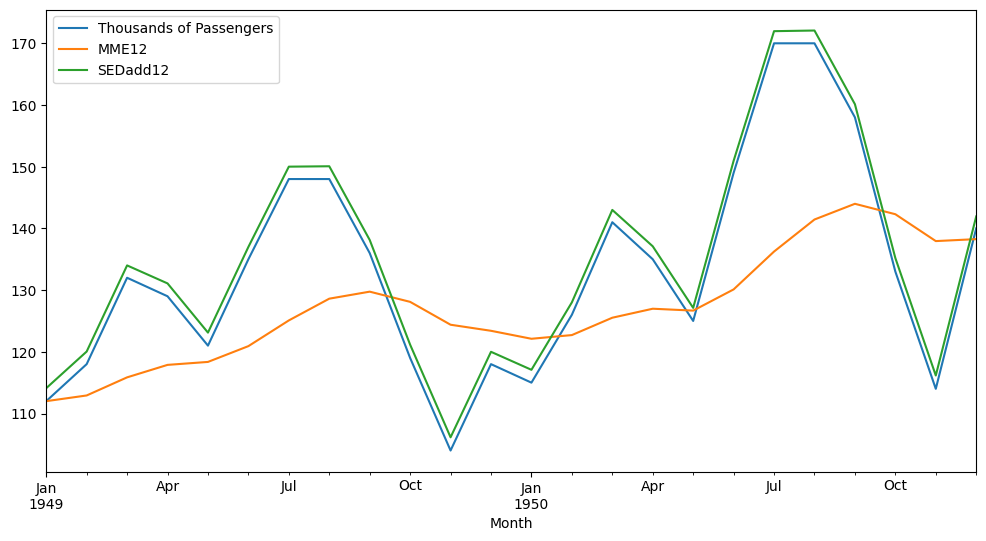

In [60]:
df[['Thousands of Passengers' , 'MME12' , 'SEDadd12']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x' , tight=True)

Here we can see that Double Exponential Smoothing is a much better representation of the time series data.<br>
Let's see if using a multiplicative seasonal adjustment helps.

Analisando o gráfico podemos notar que a Suavização Exponencial Dupla fornece uma representação muito mais acurada a respeito dos dados da série temporal. Vamos agora ver se utilizar o ajuste multiplicativo ajuda a melhorar o resultado.

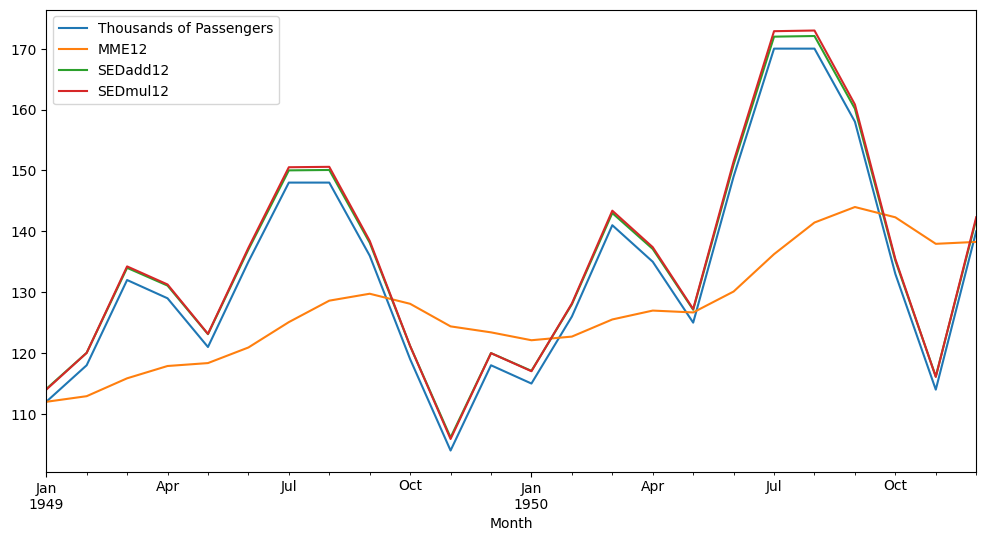

In [61]:
df['SEDmul12'] = ExponentialSmoothing(df['Thousands of Passengers'] , trend='mul').fit().fittedvalues.shift(-1)
df[['Thousands of Passengers' , 'MME12' , 'SEDadd12', 'SEDmul12']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x' , tight=True)

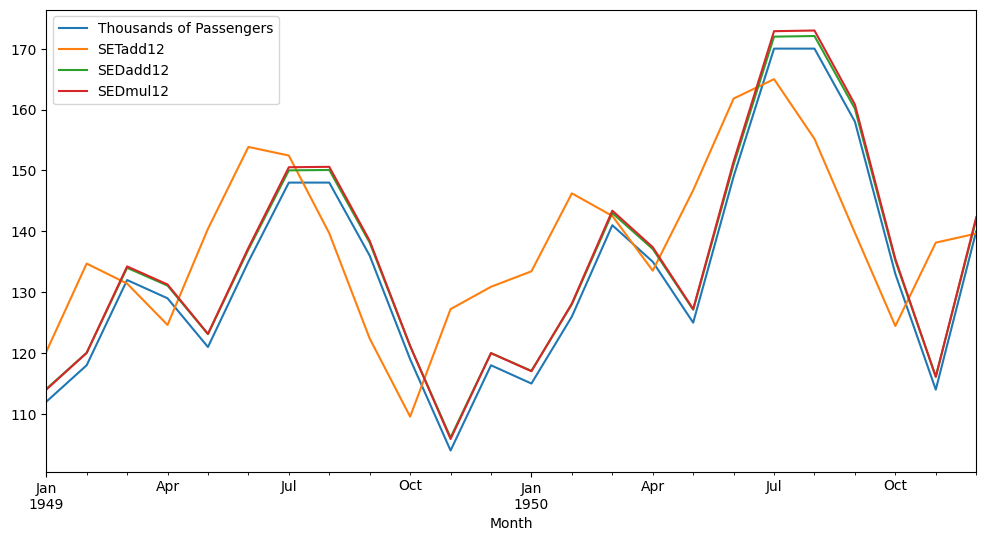

In [62]:
df['SETadd12'] = ExponentialSmoothing(df['Thousands of Passengers'] , trend='add' , seasonal='add', seasonal_periods=12).fit().fittedvalues.shift(-1)
df[['Thousands of Passengers' , 'SETadd12' , 'SEDadd12', 'SEDmul12']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x' , tight=True)

Although minor, it does appear that a multiplicative adjustment gives better results. Note that the green line almost completely overlaps the original data.

O gráfico revela que o ajuste multiplicativo gera melhores resultado. Note que a linha verde se sobrepõe a linha azul.

## Suavização Exponencial Tripla - SET

A Suavização Exponencial Tripla adiciona suporte para tendências e sazonalidade nos dados.

/home/aluno/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


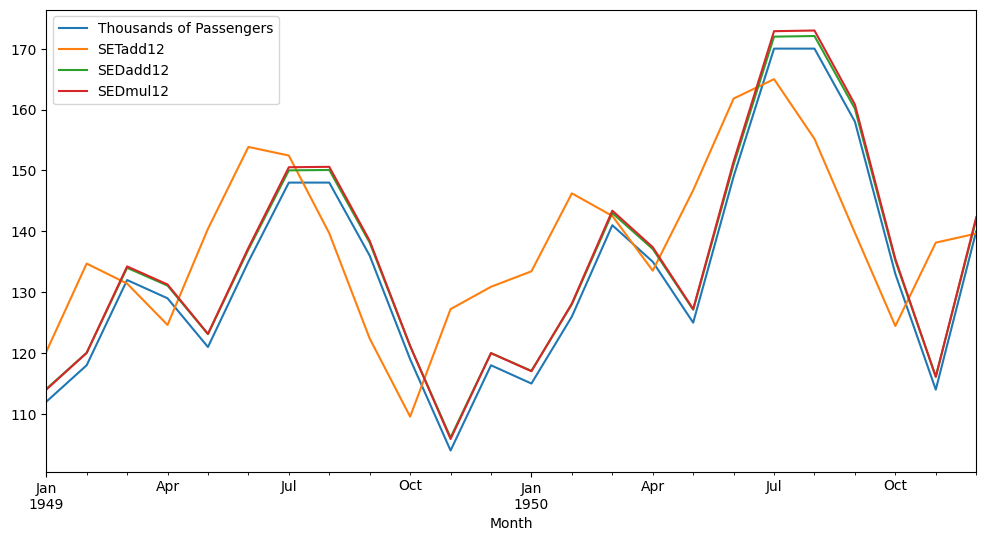

In [65]:
df['SETmul12'] = ExponentialSmoothing(df['Thousands of Passengers'] , trend='mul' , seasonal='mul', seasonal_periods=12).fit()
df[['Thousands of Passengers' ,'SETadd12', 'SETmul12' , 'SEDadd12', 'SEDmul12']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x' , tight=True)

Com base no gráfico acima, você pode pensar que a Suavização Exponencial Tripla faz um trabalho de ajuste pior do que a Suavização Exponencial Dupla. A chave aqui é considerar o que vem a seguir – <em>previsão</em>. Veremos que ter a capacidade de prever padrões sazonais flutuantes melhora muito a nossa previsão.